# No Poisonous Fungus Amungus?
## A Mushroom Identification System

Belisha Genin, Catherine Merfeld, Yangtian Yan, Yukun Liu

**This text is from our project proposal. I've edited some of it but we'll need to edit more once the project is done and we know what we want to say.**

This tool takes images of wild mushrooms and predicts their safety for human consumption. Our tool could be turned into an app for amateur mushroom foragers to use while out hiking. These individuals would be able to use the tool to decide whether a mushroom was worth picking and bringing home for further identification.


There are many other mushroom identification tools in existence. Ours has two key differences. The first is that we use a lightweight model that can run without external servers or internet connection, since we assume users may be out in the wilderness where cell service is spotty or non-existent. The second difference is that our algorithm is capable of handling black and white images or images taken in low-light. This is to keep in mind that our users would primarily be hikers who may find themselves in situations with only their device’s lighting or in other poor lighting conditions (dawn, dusk, clouds, etc.).  


The largest challenge of this project was the low-light element. Color is a distinguishing characteristic of many mushrooms, so removing this feature required us to find creative solutions to help our model correctly identify images.

**Talk about what our creative solutions were!!**


Our dataset is comprised of thousands of images of mushrooms scraped from various mycology websites including Mushroom World, Wild Food, Luonto Portii, and Foraging Guide. Images are labeled as poisonous or edible and are divided into sets for training, testing and validation.


## Let's update the rest of this when we're done!
We will rely on existing TensorFlow packages to build our image identification CNN. Google’s ImageNetV2 (trained on ImageNet) may play a role in making our model lightweight. We may end up utilizing some of the mycology references above as we try to find a strategy for dealing with black and white/low-light images.   

How will you demonstrate the usefulness of your tool?

We will showcase the efficacy of our algorithm by building a feature into our project website where users can select an image the model has never seen before (including ones in low lighting) and the model will make a prediction of either poisonous or edible.







In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import pathlib

In [25]:
train_dir = pathlib.Path('/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/train/')
test_dir = pathlib.Path('/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/test/')
validation_dir = pathlib.Path('/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/validation/')

# img_height = 360 # the default value of 256 works fine so we shouldn't need this
# img_width = 360
batch_size = 32


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels = 'inferred', # creates labels from directory structure. Because of the way we have the dir set up, this will be poisonous and edible
  # validation_split=0.2, # we already have a validation set so we don't need this split
  # subset="both", # this is used with validation_split so we don't need it
  seed=123,
  # image_size=(img_height, img_width),
  batch_size=batch_size # using batches will speed up training significantly
 )

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels = 'inferred',
  seed=123,
  # image_size=(img_height, img_width),
  batch_size=batch_size
 )

validation_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  labels = 'inferred',
  seed=123,
  # image_size=(img_height, img_width),
  batch_size=batch_size
 )

Found 4258 files belonging to 2 classes.
Found 534 files belonging to 2 classes.
Found 536 files belonging to 2 classes.


In [12]:
# generate lists of edible and poisonous mushroom images and print out length of each
images = pathlib.Path(train_dir)
edible_mushrooms = list(images.glob('edible/*'))
poisonous_mushrooms = list(images.glob('poisonous/*'))
print(len(edible_mushrooms), 'edible mushroom images in the training set.')
print(len(poisonous_mushrooms), 'poisonous mushroom images in the training set.')

2480 edible mushroom images in the training set.
1778 poisonous mushroom images in the training set.


# Data Distribution:
---
From the cell above we can see that we have 4258 training, 534 testing and 536 validation images. Within the training set we have 2480 edible musroom images and 1778 poisonous images. The breakdown of our data is not representative of the edible/poisonous mushroom ratio in nature as it is estimated that only 3% of known mushroom varieties are poisonous.

The impact of this on our model could be a high rate of false positives (incorrectly labeling edible mushrooms as poisonous). Although we prefer false positives to false negatives for our purposes, we will take steps to reduce the impact on the accuracy of our model. Our main strategies will be image augmentation and resampling of edible images.

**I think we should run the model with and without the edible image resampling** That way we our write-up can discuss the impact it made. It won't take us much extra time at all.

Here's a tool we can use for resampling: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#rejection_resample


# Visualizing Our Data:
---

Below we can see some of our test images. It is worth noting that the resolution of some images is low. We might consider removing low-resolution images to see what the imact is on our model. Some of our images also have a white border. This has the potential to be confusing for our model. Since many images have this border I'd be hesitant to remove them, but it could be worth testing. We could also try out `central_crop` from tf which removes the outer part of an image. https://www.tensorflow.org/api_docs/python/tf/image/central_crop

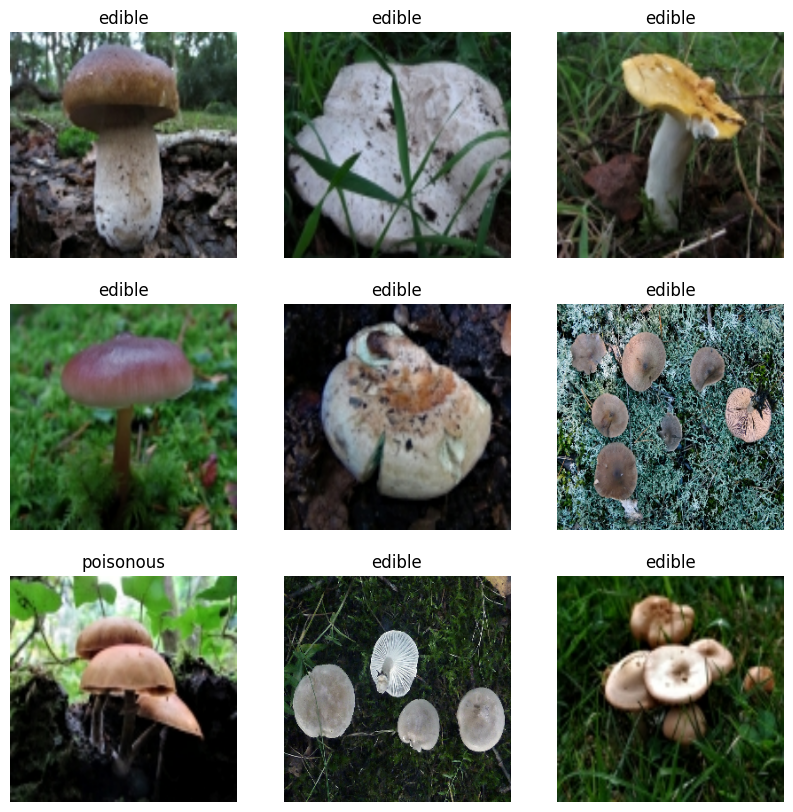

In [17]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(images[i].numpy().astype("uint8"))
   plt.title(class_names[labels[i]]) # adding class labels to images
   plt.axis("off")

# Data Augmentation:
---
We decided to use data augmentation methods for two reasons. The first is to increase the size of our dataset and deal with our class imbalance. The second is to account for the lighting conditions in which our users might be taking photos. Below we've shown some of our data before and after augmentation.

In [56]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original Image')
  plt.axis('off')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented Image')
  plt.axis('off')
  plt.imshow(augmented)
  plt.show()

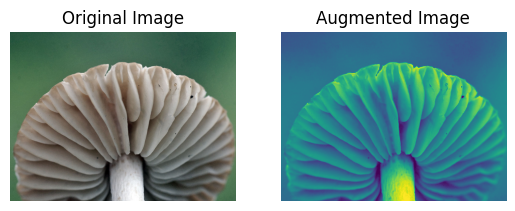

In [57]:
image = PIL.Image.open(str(edible_mushrooms[3]))
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, grayscaled)

###This filter changes the brightness of images. This might actually be more what we're looking for than the grayscale transformation.

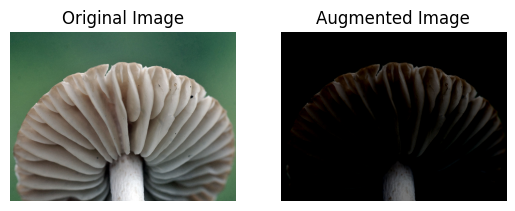

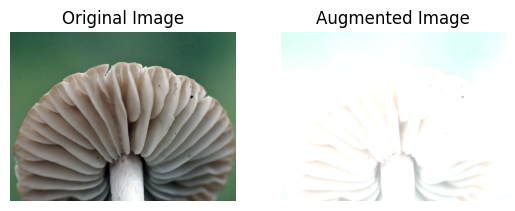

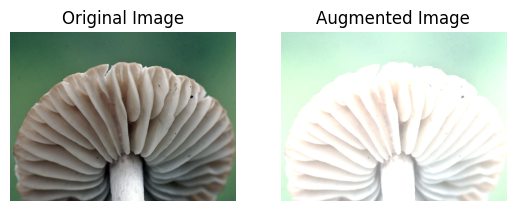

In [58]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

**We can add whatever other transformations we're doing here for visualization:**

In [1]:
# # set augmentation configuration for visualizing transformations
# data_augmentation = keras.Sequential([
#     # insert data augmentation layers here
# ])

# # run the first training image through the augmentation configuration nine times
# for image, _ in train_ds.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')